<h1> Imports and Setup </h1>

In [2]:
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras.models import load_model

#import models
from util import *
from features import *
import importlib, os, argparse, copy, time
from collections import defaultdict
import os, sys, pickle, audioread, pretty_midi, librosa, numpy as np
from sklearn.utils import shuffle
import tensorflow as tf

if 'ipykernel' in sys.modules:
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

from IPython.display import Audio as play
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches

# Takes indices into a pre-computed list of fft's and returns those fft's
def sum_component_ffts(fft_list, component_indices, energy_list=None, energy_weighted=None):
    if energy_list is not None and energy_weighted:
    # Take a weighted sum of the feature vectors, weighted by the energy of the feature vector
    # normalize by the sum of the rms   
        energies = np.array([energy_list[i] for i in component_indices])
        #ffts = np.array([fft_list[i] for i in component_indices])
        ffts = np.array([fft_list[i]*energy_list[i] for i in component_indices])
        weighted_sum = np.sum(ffts, axis=0)
        return weighted_sum / np.sum(energies)
    else:
        #Take the mean of each feature vector
        return np.mean([fft_list[i] for i in component_indices], axis=0) 

# Get a list of all the errors
def get_errors(true_mixture_ffts, predicted_ffts, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        
        if loss_fn == 'mse':
            errors.append(mean_squared_feature_distance(y_true, y_pred))
        elif loss_fn == 'mape':
            errors.append(mean_absolute_percentage_error(y_true, y_pred))
        else:
            raise("Unsupported Error Metric")
    return errors

# Compute the error as improvement relative to the baseline 
# With "baseline" meaning the average of the feature vector over all ~10K data points)
# This interpretation of the error can correct for the differences in variances of the datasets
def get_relative_errors(true_mixture_ffts, predicted_ffts, baseline_vector, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):
        y_true = true_mixture_ffts[i]
        y_pred = predicted_ffts[i]
        #baseline_error = map(lambda y_t,y_p: loss_fn(y_t, y_p), zs)
        
        if loss_fn == 'mse':
            baseline_error = mean_squared_feature_distance(y_true, baseline_vector)
            error = mean_squared_feature_distance(y_true, y_pred)
        elif loss_fn == 'mape':
            baseline_error = mean_absolute_percentage_error(y_true, baseline_vector)
            error = mean_absolute_percentage_error(y_true, y_pred)
        else:
            raise("Unsupported Error Metric")  
            
        relative_error = error/baseline_error
        errors.append(relative_error)
    return errors

# Inputs are a list of the precomputed component FFT's,
# and a list of the identities of the mixture components
def make_linear_predictions(component_ffts, mixture_component_indices, energy_list=None, energy_weighted=None):
    #preds = []
    #for i in range(len(component_ffts)):
    #    preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i]))
    #return preds
    preds = []
    for i in range(len(mixture_component_indices)):
        preds.append(sum_component_ffts(component_ffts, mixture_component_indices[i], energy_list=energy_list, energy_weighted=energy_weighted))
    return preds

def get_baseline_errors(true_mixture_ffts, baseline_vector, loss_fn='mse'):
    errors = []
    for i in range(len(true_mixture_ffts)):    
        y_true = true_mixture_ffts[i]
        y_pred = baseline_vector
        
        if loss_fn == 'mse':
            baseline_error = mean_squared_feature_distance(y_true, y_pred)
        elif loss_fn == 'mape':
            baseline_error = mean_absolute_percentage_error(y_true, y_pred) 
        else:
            raise("Unsupported Error Metric") 
            
        errors.append(baseline_error)
    return errors

def normalize_predictions(predictions, targets):
    for i in range(len(predictions)):
        try:
            max_pred = max(predictions[i])
            max_target = max(targets[i])
            if max_target == 0:
                max_target = 0.000001
            if max_pred ==0:
                max_pred = 0.000001
            ratio = max_pred/max_target
        except:
            ratio = 9999999
        predictions[i] = predictions[i]/ratio

<h1> Load Data </h1>

In [ ]:
train_mixture_datasets = defaultdict(None)
dev_mixture_datasets = defaultdict(None)
test_mixture_datasets = defaultdict(None)

root_path = 'generated_data'

train_mixture_datasets = defaultdict(None)
dev_mixture_datasets = defaultdict(None)
test_mixture_datasets = defaultdict(None)

mixture_values = [2,3,6,12,20,30]

# load training data
# FFT
with open(f"{root_path}/train/train_weighted_ffts.pkl", "rb") as f:
    train_weighted_ffts = pickle.load(f)

with open(f"{root_path}/train/train_energies.pkl", "rb") as f:
    train_energies = pickle.load(f)

# MFCC
with open(f"{root_path}/train/train_weighted_mfccs.pkl", "rb") as f:
    train_weighted_mfccs = pickle.load(f)
    
for m in mixture_values:
    with open(f"{root_path}/train/mixture_data_{m}.pkl", "rb") as f:
        train_mixture_datasets[m] = pickle.load(f)
             
# load dev data
# FFT
with open(f"{root_path}/dev/dev_weighted_ffts.pkl", "rb") as f:
    dev_weighted_ffts = pickle.load(f)
    
with open(f"{root_path}/dev/dev_energies.pkl", "rb") as f:
    dev_energies = pickle.load(f)

# MFCC
with open(f"{root_path}/dev/dev_weighted_mfccs.pkl", "rb") as f:
    dev_weighted_mfccs = pickle.load(f)
    
for m in mixture_values:
    with open(f"{root_path}/dev/mixture_data_{m}.pkl", 'rb') as f:
        dev_mixture_datasets[m] = pickle.load(f)
        
# load test data
# FFT
with open(f"{root_path}/test/test_weighted_ffts.pkl", "rb") as f:
    test_weighted_ffts = pickle.load(f)
    
with open(f"{root_path}/test/test_energies.pkl", "rb") as f:
    test_energies = pickle.load(f)
    
# MFCC
with open(f"{root_path}/test/test_weighted_mfccs.pkl", "rb") as f:
    test_weighted_mfccs = pickle.load(f)

for m in mixture_values:
    with open(f"{root_path}/test/mixture_data_{m}.pkl", 'rb') as f:
        test_mixture_datasets[m] = pickle.load(f)
        
# Normalize all fft data
for m in mixture_values:
    d = train_mixture_datasets[m]
    apply_max_norm(d['mix_ffts'])
    d = dev_mixture_datasets[m]
    apply_max_norm(d['mix_ffts'])
    d = test_mixture_datasets[m]
    apply_max_norm(d['mix_ffts'])
    
apply_max_norm(train_weighted_ffts)
apply_max_norm(dev_weighted_ffts)
apply_max_norm(test_weighted_ffts)

# Compute the mean mixture FFT's and MFCC's for all datasets to use as a baseline
#for data in [train_mixture_datasets, dev_mixture_datasets, test_mixture_datasets]:
for data in [train_mixture_datasets, dev_mixture_datasets]:    
    for m in mixture_values:
        data[m]['mean_fft'] = np.mean(data[m]['mix_ffts'], axis=0)
        data[m]['mean_mfcc'] = np.mean(data[m]['mix_mfccs'], axis=0)

<h1> MFCC Prediction Analysis </h1>

In [ ]:
mfcc_mlp_models = load_models_from_dir("saved_models/mfcc/mlp")
mfcc_lstm_models_ordered = load_models_from_dir("saved_models/mfcc/lstm_ordered/")
mfcc_lstm_models_unordered = load_models_from_dir("saved_models/mfcc/lstm_unordered/")
mfcc_lstm_models_residual = load_models_from_dir("saved_models/mfcc/lstm_residual/")

Linear Error (mean):  0.4330715030859702 Linear Error (energy weighted):  0.36334765884807596 MLP Error:  0.41877963736046125 LSTM Unordered Error:  0.30242575933403015 LSTM Ordered Error:  0.30265318263939495 LSTM Residual Error:  0.3159060206568935
Linear Error (mean):  0.5767189681667562 Linear Error (energy weighted):  0.5853892932900894 MLP Error:  0.5523079934186128 LSTM Unordered Error:  0.4552467629332859 LSTM Ordered Error:  0.45949380614693225 LSTM Residual Error:  0.473845221417526
Linear Error (mean):  0.8140054404582281 Linear Error (energy weighted):  0.9425330572958969 MLP Error:  0.7126611655643824 LSTM Unordered Error:  0.5733283179184018 LSTM Ordered Error:  0.6107360678554614 LSTM Residual Error:  0.63508690759881
Linear Error (mean):  1.0339261450884605 Linear Error (energy weighted):  1.3012376948178963 MLP Error:  0.7884003895862282 LSTM Unordered Error:  0.632108132248463 LSTM Ordered Error:  0.6571551334112473 LSTM Residual Error:  0.7132114390421936
Linear Erro

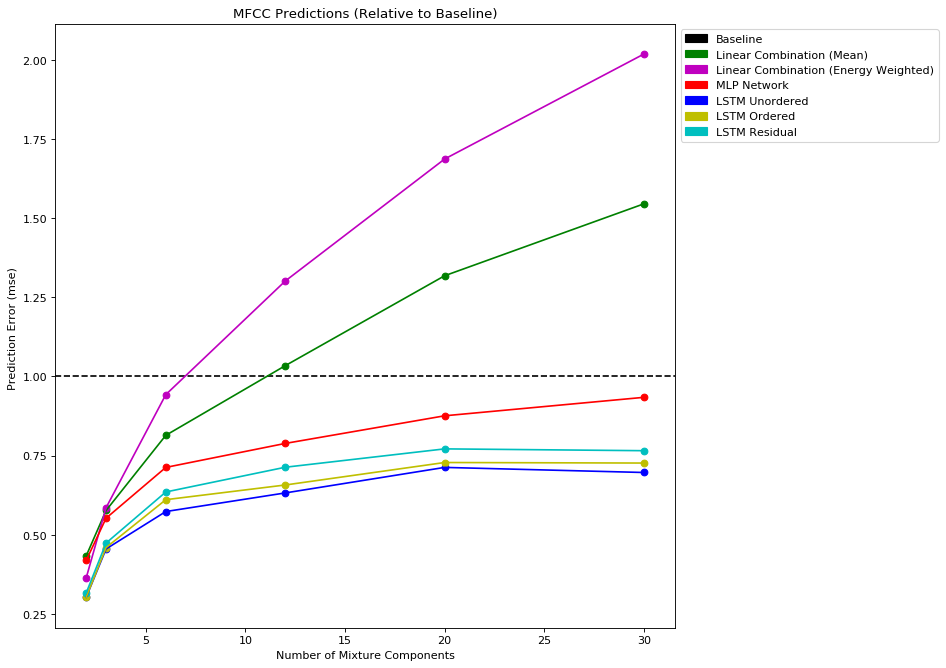

In [125]:
# Compute "True" MFCC error on dev data for MSE
baseline_errors_per_dataset_ = []
linear_errors_per_dataset = []
linear_errors_energy_weighted_per_dataset = []
mlp_errors_per_dataset = []
lstm_unordered_errors_per_dataset = []
lstm_ordered_errors_per_dataset = []
lstm_residual_errors_per_dataset = []

relative_errors = True
loss_fn = "mse"

values_of_m = copy.deepcopy(mixture_values)[0:-1]

for m in values_of_m:
    source_energies = copy.deepcopy(dev_energies)
    dev_mix_mfccs = dev_mixture_datasets[m]['mix_mfccs']
    
    X_dev = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs))
    X_dev_lstm = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs, flatten=False))
    y_dev = copy.deepcopy(dev_mix_mfccs)
    X_dev_lstm_ordered = copy.deepcopy(get_mfcc_inputs(dev_mixture_datasets[m], dev_weighted_mfccs, flatten=False))
    X_dev_lstm_ordered = order_dataset_by_norm(X_dev_lstm_ordered)
    
    linear_predictions = make_linear_predictions(dev_weighted_mfccs, dev_mixture_datasets[m]['components'], energy_list=source_energies, energy_weighted=False)
    linear_predictions_energy_weighted = make_linear_predictions(dev_weighted_mfccs, dev_mixture_datasets[m]['components'], energy_list=source_energies, energy_weighted=True) 
    mlp_predictions = mlp_models_mfcc[m].predict(X_dev, batch_size=200) 
    lstm_unordered_predictions = mfcc_lstm_models_unordered[m].predict(X_dev_lstm, batch_size=200)
    lstm_ordered_predictions = mfcc_lstm_models_ordered[m].predict(X_dev_lstm_ordered, batch_size=200)
    lstm_residual_predictions = mfcc_lstm_models_residual[m].predict(X_dev_lstm_ordered, batch_size=200)


    if relative_errors:
        linear_errors = get_relative_errors(y_dev, linear_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        linear_errors_energy_weighted = get_relative_errors(y_dev, linear_predictions_energy_weighted, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        mlp_errors = get_relative_errors(y_dev, mlp_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        lstm_unordered_errors = get_relative_errors(y_dev, lstm_unordered_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        lstm_ordered_errors = get_relative_errors(y_dev, lstm_ordered_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        lstm_residual_errors = get_relative_errors(y_dev, lstm_residual_predictions, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
    else:
        linear_errors = get_errors(y_dev, linear_predictions, loss_fn=loss_fn)
        mlp_errors = get_errors(y_dev, mlp_predictions, loss_fn=loss_fn)
        #mlp_errors_two_layer = get_errors(y_dev, mlp_predictions_two_layer, loss_fn=loss_fn)
        #mlp_fft_errors = get_errors(y_dev, mlp_fft_predictions, loss_fn=loss_fn)
        lstm_errors = get_errors(y_dev, lstm_predictions, loss_fn=loss_fn)
        baseline_errors = get_baseline_errors(y_dev, dev_mixture_datasets[m]['mean_mfcc'], loss_fn=loss_fn)
        
    linear_errors_per_dataset.append(linear_errors)
    linear_errors_energy_weighted_per_dataset.append(linear_errors_energy_weighted)
    mlp_errors_per_dataset.append(mlp_errors)
    lstm_unordered_errors_per_dataset.append(lstm_unordered_errors)
    lstm_ordered_errors_per_dataset.append(lstm_ordered_errors)
    lstm_residual_errors_per_dataset.append(lstm_residual_errors) 
    
    
    print("Linear Error (mean): ", np.mean(linear_errors),
          "Linear Error (energy weighted): ", np.mean(linear_errors_energy_weighted),
          "MLP Error: ", np.mean(mlp_errors)
         ,"LSTM Unordered Error: ", np.mean(lstm_unordered_errors)
         ,"LSTM Ordered Error: ", np.mean(lstm_ordered_errors)
         ,"LSTM Residual Error: ", np.mean(lstm_residual_errors))

fig = plt.figure(figsize=(10,10),dpi=80)    
    
handles = [mpatches.Patch(color='black',label='Baseline'),
           mpatches.Patch(color='g',label='Linear Combination (Mean)'),
           mpatches.Patch(color='m',label='Linear Combination (Energy Weighted)'),
           mpatches.Patch(color='r',label='MLP Network'),
           mpatches.Patch(color='b',label='LSTM Unordered'),
           mpatches.Patch(color='y',label='LSTM Ordered'),
           mpatches.Patch(color='c',label='LSTM Residual')
          ]
    
if relative_errors:
    plt.title("MFCC Predictions (Relative to Baseline)")
    plt.axhline(y=1, color='black', linestyle='--')
else:
    plt.title("MFCC Predictions (Raw)")
    plt.plot(values_of_m, [np.mean(e) for e in baseline_errors_per_dataset], c = 'black', linestyle='--')

#plt.yscale('log')
   

    
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error (%s) " % (loss_fn))

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_energy_weighted_per_dataset], c = 'm')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_energy_weighted_per_dataset], c = 'm')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_unordered_errors_per_dataset], c = 'b')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_unordered_errors_per_dataset], c = 'b')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_ordered_errors_per_dataset], c = 'y')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_ordered_errors_per_dataset], c = 'y')
         
_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_residual_errors_per_dataset], c = 'c')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_residual_errors_per_dataset], c = 'c')
plt.legend(bbox_to_anchor=(1, 1),handles=handles)

<h1> FFT Prediction Analysis </h1>

In [ ]:
# change this path if you saved your models somewhere other than 'saved_models'
output_path = "saved_models"

def load_models_from_dir(d):
    pkl_files = [f for f in os.listdir(d) if f.endswith('.pkl')]
    data = defaultdict(None)
    for f in tqdm(pkl_files):
        # Get the number of mixtures M from the filename
        # Assuming the naming is consistent with train.py
        full_path = os.path.join(d, f)
        m = int(f.split('.pkl')[0].split('_')[1])
        data[m] = load_model(full_path)
    return data

In [ ]:
fft_mlp_models = load_models_from_dir("saved_models/fft/mlp")
fft_lstm_models_ordered = load_models_from_dir("saved_models/fft/lstm_ordered/")
fft_lstm_models_unordered = load_models_from_dir("saved_models/fft/lstm_unordered/")
fft_lstm_models_residual = load_models_from_dir("saved_models/fft/lstm_residual/")

Linear Error (mean):  0.44427055281904915 Linear Error (energy weighted):  0.14745994659438302 MLP Error:  0.7247911308603339 LSTM Unordered Error:  0.53504056252211 LSTM Ordered Error:  0.5505909086868183 LSTM Residual Error:  0.4914863590130604
Linear Error (mean):  0.5995760056121677 Linear Error (energy weighted):  0.25147846973181776 MLP Error:  1.0968918095755325 LSTM Unordered Error:  0.6920246735825505 LSTM Ordered Error:  0.7337787547938744 LSTM Residual Error:  0.6724100730827569
Linear Error (mean):  0.730067790772103 Linear Error (energy weighted):  0.40990253091275813 MLP Error:  1.227777098928998 LSTM Unordered Error:  0.7825958372092513 LSTM Ordered Error:  0.8461174664191253 LSTM Residual Error:  0.8414117946067465
Linear Error (mean):  0.850411515854129 Linear Error (energy weighted):  0.620186084638176 MLP Error:  1.2387731598819103 LSTM Unordered Error:  0.8084920721713065 LSTM Ordered Error:  0.8824728199207057 LSTM Residual Error:  0.8505890569567792
Linear Error (

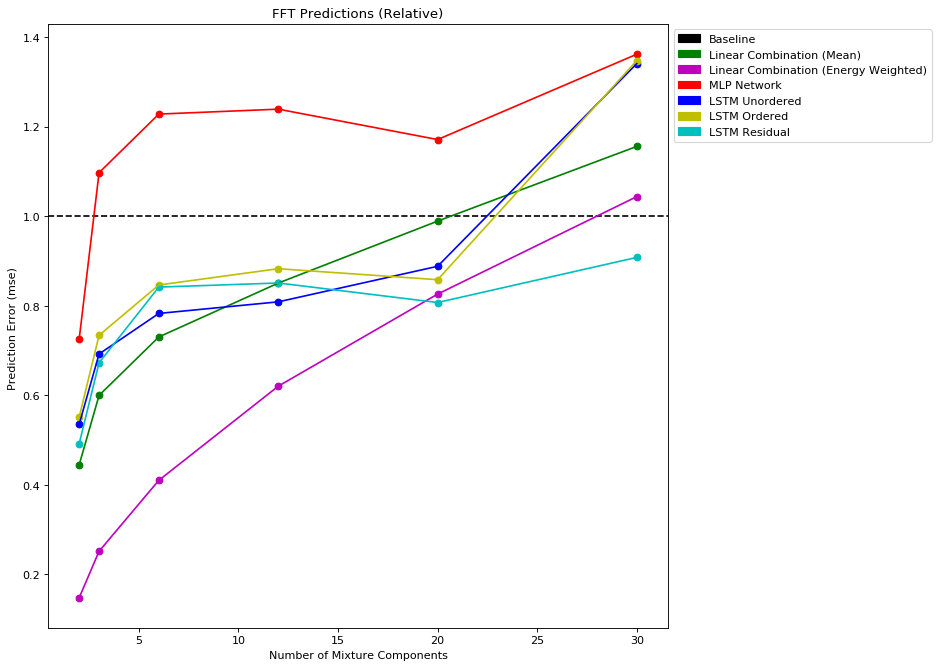

In [124]:
# Compute "True" FFT error on dev data FOR MSE
baseline_errors_per_dataset = []
linear_errors_per_dataset = []
linear_errors_energy_weighted_per_dataset = []
mlp_errors_per_dataset = []
lstm_unordered_errors_per_dataset = []
lstm_ordered_errors_per_dataset = []
lstm_residual_errors_per_dataset = []

relative_errors = True
loss_fn = "mse"

values_of_m = copy.deepcopy(mixture_values)[0:-1]

for m in values_of_m:
    dev_mix_ffts = np.array(dev_mixture_datasets[m]['mix_ffts'])
    
    X_dev = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts))
    X_dev_lstm = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts, flatten=False))
    y_dev = copy.deepcopy(dev_mix_ffts)
    
    X_dev_lstm_ordered = copy.deepcopy(get_fft_inputs(dev_mixture_datasets[m], dev_weighted_ffts, flatten=False))
    X_dev_lstm_ordered = order_dataset_by_norm(X_dev_lstm_ordered)
    
    #max_norm(y_dev)
    
    source_fft_data = copy.deepcopy(dev_weighted_ffts)
    source_energies = copy.deepcopy(dev_energies)

    linear_predictions = make_linear_predictions(source_fft_data, dev_mixture_datasets[m]['components'], energy_list = source_energies, energy_weighted=False)
    linear_predictions_energy_weighted = make_linear_predictions(source_fft_data, dev_mixture_datasets[m]['components'], energy_list = source_energies, energy_weighted=True)
    mlp_predictions = fft_mlp_models[m].predict(X_dev, batch_size=200)  
    lstm_unordered_predictions = fft_lstm_models_unordered[m].predict(X_dev_lstm, batch_size=200) 
    lstm_ordered_predictions = fft_lstm_models_ordered[m].predict(X_dev_lstm_ordered, batch_size=200)
    lstm_residual_predictions = fft_lstm_models_ordered_residual[m].predict(X_dev_lstm_ordered, batch_size=200)
    
    
    if relative_errors:
        linear_errors = get_relative_errors(y_dev, linear_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        linear_errors_energy_weighted = get_relative_errors(y_dev, linear_predictions_energy_weighted, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        mlp_errors = get_relative_errors(y_dev, mlp_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        lstm_unordered_errors = get_relative_errors(y_dev, lstm_unordered_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        lstm_ordered_errors = get_relative_errors(y_dev, lstm_ordered_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        lstm_residual_errors = get_relative_errors(y_dev, lstm_residual_predictions, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
    else:
        linear_errors = get_errors(y_dev, linear_predictions, loss_fn=loss_fn)
        mlp_errors = get_errors(y_dev, mlp_predictions, loss_fn=loss_fn)
        #mlp_errors_two_layer = get_errors(y_dev, mlp_predictions_two_layer, loss_fn=loss_fn)
        lstm_errors = get_errors(y_dev, lstm_predictions, loss_fn=loss_fn)
        #lstm_positive_errors = get_errors(y_dev, lstm_positive_predictions, loss_fn=loss_fn)
        #lstm_together_errors = get_errors(y_dev, lstm_together_predictions, loss_fn=loss_fn)
        baseline_errors = get_baseline_errors(y_dev, dev_mixture_datasets[m]['mean_fft'], loss_fn=loss_fn)
        baseline_errors_per_dataset.append(baseline_errors)
    
    linear_errors_per_dataset.append(linear_errors)
    linear_errors_energy_weighted_per_dataset.append(linear_errors_energy_weighted)
    mlp_errors_per_dataset.append(mlp_errors)
    lstm_unordered_errors_per_dataset.append(lstm_unordered_errors)
    lstm_ordered_errors_per_dataset.append(lstm_ordered_errors)
    lstm_residual_errors_per_dataset.append(lstm_residual_errors)    
    
    
    print("Linear Error (mean): ", np.mean(linear_errors),
          "Linear Error (energy weighted): ", np.mean(linear_errors_energy_weighted),
          "MLP Error: ", np.mean(mlp_errors)
         ,"LSTM Unordered Error: ", np.mean(lstm_unordered_errors)
         ,"LSTM Ordered Error: ", np.mean(lstm_ordered_errors)
         ,"LSTM Residual Error: ", np.mean(lstm_residual_errors))

    #_ = plt.hist(errors, bins=50)

fig = plt.figure(figsize=(10,10),dpi=80)      
    
handles = [mpatches.Patch(color='black',label='Baseline'),
           mpatches.Patch(color='g',label='Linear Combination (Mean)'),
           mpatches.Patch(color='m',label='Linear Combination (Energy Weighted)'),
           mpatches.Patch(color='r',label='MLP Network'),
           mpatches.Patch(color='b',label='LSTM Unordered'),
           mpatches.Patch(color='y',label='LSTM Ordered'),
           mpatches.Patch(color='c',label='LSTM Residual')
          ]

if relative_errors:
    plt.title("FFT Predictions (Relative)")
    plt.axhline(y=1, color='black', linestyle='--')
else:
    plt.title("FFT Predictions (Raw)")
    plt.plot(mixture_values, [np.mean(e) for e in baseline_errors_per_dataset], c = 'black', linestyle='--')
    
#plt.yscale('log')
    
plt.xlabel("Number of Mixture Components")
plt.ylabel("Prediction Error (%s) " % (loss_fn))

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_per_dataset], c = 'g')

_ = plt.plot(values_of_m, [np.mean(e) for e in linear_errors_energy_weighted_per_dataset], c = 'm')
_ = plt.scatter(values_of_m, [np.mean(e) for e in linear_errors_energy_weighted_per_dataset], c = 'm')

_ = plt.plot(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')
_ = plt.scatter(values_of_m, [np.mean(e) for e in mlp_errors_per_dataset], c = 'r')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_unordered_errors_per_dataset], c = 'b')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_unordered_errors_per_dataset], c = 'b')

_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_ordered_errors_per_dataset], c = 'y')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_ordered_errors_per_dataset], c = 'y')
         
_ = plt.plot(values_of_m, [np.mean(e) for e in lstm_residual_errors_per_dataset], c = 'c')
_ = plt.scatter(values_of_m, [np.mean(e) for e in lstm_residual_errors_per_dataset], c = 'c')

plt.legend(bbox_to_anchor=(1, 1),handles=handles)

<h1> Calculate computation time for models and real features </h1>

In [21]:
mixes, components, mixture_coefs = make_mixes(dev_signals, 30, 2000)

100%|██████████| 2000/2000 [01:44<00:00, 19.04it/s]


In [26]:
# CALCULATE TIME TO COMPUTE REAL THE FFT features for 2000 examples
from joblib import Parallel, delayed
def parallel_stft(signals, n_processes, sr=None):
    return Parallel(n_jobs=n_processes)(
        delayed(energy_weighted_fft)(y) for y in signals)

def parallel_mfcc(signals, n_processes, sr=None):
    return Parallel(n_jobs=n_processes)(
        delayed(energy_weighted_mfcc)(y) for y in signals)

print("FFT time:")
t0 = time.time()
pstft = parallel_stft(mixes, n_processes=20)
print(time.time()-t0)

print("MFCC time:")
t0 = time.time()
pstft = parallel_mfcc(mixes, n_processes=20)
print(time.time()-t0)

FFT time:
14.712657451629639
MFCC time:
73.40183091163635


In [48]:
# CALCULATE TIME FOR RESIDUAL LSTM on 30 FFT mixtures to make 2000 predictions using GPU
X_dev = get_fft_inputs(dev_mixture_datasets[30], dev_weighted_ffts, flatten=False)
t0 = time.time()
fft_lstm_models_ordered_residual[30].predict(X_dev, batch_size=2000)
print(time.time()-t0)

# CALCULATE TIME FOR RESIDUAL LSTM on 2 FFT mixtures to make 2000 predictions using GPU
X_dev = get_fft_inputs(dev_mixture_datasets[2], dev_weighted_ffts, flatten=False)
t0 = time.time()
fft_lstm_models_ordered_residual[2].predict(X_dev, batch_size=2000)
print(time.time()-t0)

1.1759552955627441
0.06719446182250977


In [41]:
# CPU # CALCULATE TIME FOR RESIDUAL LSTM on 30 FFT mixtures to make 2000 predictions using CPU
X_dev = get_fft_inputs(dev_mixture_datasets[30], dev_weighted_ffts, flatten=False)
t0 = time.time()
fft_lstm_models_ordered_residual[30].predict(X_dev, batch_size=2000)
print(time.time()-t0)

# CPU # CALCULATE TIME FOR RESIDUAL LSTM on 2 FFT mixtures to make 2000 predictions using CPU
X_dev = get_fft_inputs(dev_mixture_datasets[2], dev_weighted_ffts, flatten=False)
t0 = time.time()
fft_lstm_models_ordered_residual[2].predict(X_dev, batch_size=2000)
print(time.time()-t0)

4.746749401092529
0.3540019989013672


In [43]:
# CALCULATE TIME FOR RESIDUAL LSTM on 30 MFCC mixtures to make 2000 predictions using GPU
X_dev = get_mfcc_inputs(dev_mixture_datasets[30], dev_weighted_mfccs, flatten=False)
t0 = time.time()
mfcc_lstm_models_residual[30].predict(X_dev, batch_size=2000)
print(time.time()-t0)

# CALCULATE TIME FOR RESIDUAL LSTM on 2 MFCC mixtures to make 2000 predictions using GPU
X_dev = get_mfcc_inputs(dev_mixture_datasets[2], dev_weighted_mfccs, flatten=False)
t0 = time.time()
mfcc_lstm_models_residual[2].predict(X_dev, batch_size=2000)
print(time.time()-t0)

0.3276844024658203
0.02803206443786621


In [45]:
# CPU CALCULATE TIME FOR RESIDUAL LSTM on 30 MFCC mixtures to make 2000 predictions using CPU
X_dev = get_mfcc_inputs(dev_mixture_datasets[30], dev_weighted_mfccs, flatten=False)
t0 = time.time()
mfcc_lstm_models_residual[30].predict(X_dev, batch_size=2000)
print(time.time()-t0)

# CPU CALCULATE TIME FOR RESIDUAL LSTM on 2 MFCC mixtures to make 2000 predictions using CPU
X_dev = get_mfcc_inputs(dev_mixture_datasets[2], dev_weighted_mfccs, flatten=False)
t0 = time.time()
mfcc_lstm_models_residual[2].predict(X_dev, batch_size=2000)
print(time.time()-t0)

0.3394744396209717
0.02767467498779297
